In [11]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [4]:
# convert to geodf for spatial join

df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [5]:
# convert date column from string to datetime.

df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

[None, None]

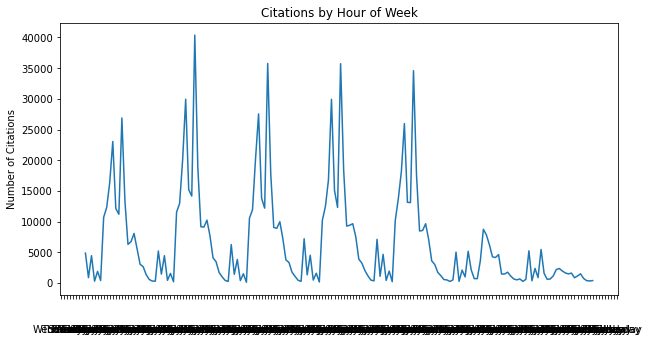

In [24]:
ax1 = df.groupby((df['Citation Issued DateTime'].dt.dayofweek) * 24 + (df['Citation Issued DateTime'].dt.hour)).size().plot(kind='line', 
title='Citations by Hour of Week', figsize=(10,5))
ax1.set(xlabel='', ylabel='Number of Citations')
ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    #minor_locator=mdates.HourLocator((0, 12)),
    #minor_formatter=mdates.DateFormatter("%H"),
)

In [ ]:
fig, ax2 = plt.subplots(figsize=(10,5))
ax2.set(xlabel='', ylabel='Total Number of Citations')
ax2.plot(df['Citation Issued DateTime'], df)
